In [1]:
from datasets import load_dataset
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import numpy as np

/Users/andrey/Documents/_Artemis_tum/Semester5/MWAHAHA_Competition/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
ds = load_dataset("SocialGrep/one-million-reddit-jokes")
one_million_jokes = ds['train'].to_pandas()

In [3]:
import re

one_million_jokes_clean = one_million_jokes[['title','selftext','score']]

selftexts_to_filter = ['[removed]', '[deleted]', r'\[removed\]', '\[deleted\]', '[Removed]', '[Deleted]', r'\[Removed\]', '\[Deleted\]']

base_mask = (
    one_million_jokes_clean['selftext'].isna() |
    one_million_jokes_clean['selftext'].isin(selftexts_to_filter) |
    one_million_jokes_clean['title'].isna() |
    one_million_jokes_clean['title'].isin(selftexts_to_filter)
)

# match exactly "\n\nEDIT" (or literal "\\n\\nEDIT"), case-insensitive
edit_pattern = r'(?:\n\n|\\n\\n)EDIT\b'

edit_mask = one_million_jokes_clean['selftext'].str.contains(
    edit_pattern,
    flags=re.IGNORECASE,
    na=False,
    regex=True,
)

mask = base_mask | edit_mask

one_million_jokes_clean = one_million_jokes_clean[~mask].reset_index(drop=True)


In [4]:
one_million_jokes_clean = one_million_jokes_clean[one_million_jokes_clean['score'] >= 5]

In [5]:
one_million_jokes_clean

,title,selftext,score
1,Did you know Google now has a platform for rec...,It's called Google Sheets.,9
2,What is the difference between my wife and my ...,The vacuum doesn't snore after sex.\n\n&amp;#x...,15
6,On my 18th birthday my friend introduced me to...,I was happy to meat her.,11
7,Which animal has the softest bite?,“Gummy” bears,18
12,Husband: I cheated on you once,Wife: well if we are coming clean I cheated on...,26
...,...,...,...
570330,Not so funny after all.,Little Jimmy came home from school one day and...,11
570332,My parents always said I was artistic.,"They were very modest, so they only ever whisp...",11
570337,Courtesy of my ECON professor,Two men decide to go fishing on a Saturday. T...,19
570342,A man received the following text from his nei...,I am so sorry Bob. I've been riddled with guil...,21


In [6]:
one_million_jokes_clean['title'].value_counts()

title
A man walks into a bar                                           143
What do you call a cheap circumcision?                           122
A man walks into a bar...                                        119
Knock knock                                                      106
Why did the chicken cross the road?                               95
                                                                ... 
What do you get when you mix multiple metals and a reptile         1
I hired the most obese personal assistant I could find.            1
An elderly man and his wife went to the state fair every year      1
Police were called to my kids daycare today.                       1
A man received the following text from his neighbour....           1
Name: count, Length: 254157, dtype: int64

In [7]:
# one row per joke
# columns: title (setup), selftext (punchline / body), score
df = one_million_jokes_clean.copy()


In [8]:
df.shape

(287010, 3)

In [9]:
META_KEYWORDS = [
    "credit", "thanks for", "thanks to",
    "crosspost", "x-post", "xpost",
    "translated from", "heard this joke",
    "from my favourite", "from my favorite",
    "from the sopranos", "from my dad", "told to me by",
    "sorry for the formatting", "on mobile",
    "first post", "oc", "original content",
    "upvote", "downvote", "karma",
    "reddit.com", "r/", "/r/",
    "nsfw", "trigger warning", "spoiler",
    "feel free to", "please comment",
]

def strip_intrusive_tail(text: str) -> str:
    """Remove EDIT blocks, credits, and meta tails from the *end* of a joke."""
    if not isinstance(text, str) or not text:
        return text
    t = text

    # 1) Cut everything from the first "\n\nEDIT" (or "\\n\\nEDIT") to the end
    m = re.search(r'(?:\n\n|\\n\\n)\s*edit\b', t, flags=re.IGNORECASE)
    if m:
        t = t[:m.start()].rstrip()

    # 2) Drop a trailing URL
    t = re.sub(r'\s*https?://\S+\s*$', "", t, flags=re.IGNORECASE)

    # 3) Trailing parentheses with meta keywords or person-like name
    m = re.search(r'\(([^()]*)\)\s*$', t, flags=re.UNICODE)
    if m:
        tail = m.group(1).strip()
        tail_lower = tail.lower()

        has_meta = any(k in tail_lower for k in META_KEYWORDS)
        has_name = re.search(r'\b[A-Z][a-z]{2,}\s+[A-Z][a-z]{2,}\b', tail)

        if has_meta or has_name:
            # cut off the whole "(...)" part
            t = t[:m.start()].rstrip()

    # 4) Credits after a dash at the end: '"... joke ..." - Name, 2018'
    t = re.sub(
        r'\s*[-–—]\s*(?:by\s+)?(?:[A-Z][a-z]{2,}\s+){1,3}[A-Z][a-z]{2,}(?:\s*,\s*\d{4})?\s*$',
        "",
        t,
        flags=re.UNICODE,
    ).rstrip()

    # 5) Meta keywords very near the end: cut from keyword to end
    tail_span = 120
    if len(t) <= tail_span:
        start = 0
    else:
        start = len(t) - tail_span

    search_region = t[start:].lower()
    first_pos = None
    for kw in META_KEYWORDS:
        pos = search_region.find(kw)
        if pos != -1:
            abs_pos = start + pos
            if first_pos is None or abs_pos < first_pos:
                first_pos = abs_pos

    if first_pos is not None:
        t = t[:first_pos].rstrip()

    return t


In [10]:
import re
import pandas as pd

def normalize_for_dedup(text: str) -> str:
    """
    Aggressive normalization for comparison only:
    - lowercase
    - remove ALL non-word characters (punctuation, spaces, tabs, newlines, etc.)
    """
    if pd.isna(text):
        return ""
    t = str(text).lower()
    
    t = re.sub(r"\\[nrt]", "", t)
    # keep only letters, digits and underscore; drop everything else
    t = re.sub(r"\W+", "", t, flags=re.UNICODE)
    return t


In [11]:
print(normalize_for_dedup('– “Usually an overdose.”'))
# -> 'usuallyanoverdose'
print(normalize_for_dedup('"Usually an overdose."'))
# -> 'usuallyanoverdose'

print(normalize_for_dedup('"AIRPLANE NOISES!"\n\n"When do we want them?"\n\n"NEEEEOOOWWWWW"\n\nI\'m very sorry"'))


usuallyanoverdose
usuallyanoverdose
airplanenoiseswhendowewantthemneeeeooowwwwwimverysorry


In [12]:
df = one_million_jokes_clean.copy()

# fill NaNs and convert to string
for col in ["title", "selftext"]:
    df[col] = df[col].fillna("").astype(str)
    # strip intrusive tails first
    df[col] = df[col].map(strip_intrusive_tail)

# now normalize for dedup on the *cleaned* text
df["title_norm"]    = df["title"].map(normalize_for_dedup)
df["selftext_norm"] = df["selftext"].map(normalize_for_dedup)

df["cluster_key"] = df["title_norm"] + " || " + df["selftext_norm"]



In [13]:
def keep_central_score_median(group: pd.DataFrame) -> pd.DataFrame:
    # median score of this cluster
    target = group["score"].median()
    # index of row closest to median
    idx = (group["score"] - target).abs().idxmin()
    return group.loc[[idx]]  # keep it as a DataFrame

df_dedup = (
    df
    .groupby("cluster_key", group_keys=False)
    .apply(keep_central_score_median)
    .reset_index(drop=True)
)

# drop helper columns
df_dedup = df_dedup.drop(columns=["title_norm", "selftext_norm", "cluster_key"])

print("Original:", len(df), "rows")
print("Deduped :", len(df_dedup), "rows")


Original: 287010 rows
Deduped : 262212 rows


/var/folders/2q/qf84z8xs67vfwjt96dblpb9c0000gn/T/ipykernel_6997/554636168.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df


In [14]:
one_million_jokes_dpo = df_dedup.copy()

In [15]:
one_million_jokes_dpo = one_million_jokes_dpo.rename(columns={
    "title": "setup",          
    "selftext": "punchline",   
})

one_million_jokes_dpo["setup"] = one_million_jokes_dpo["setup"].fillna("").str.strip()
one_million_jokes_dpo["punchline"] = one_million_jokes_dpo["punchline"].fillna("").str.strip()
one_million_jokes_dpo = one_million_jokes_dpo[(one_million_jokes_dpo["setup"] != "") & (one_million_jokes_dpo["punchline"] != "")]

In [16]:
one_million_jokes_dpo

,setup,punchline,score
2,[,12 years old and mixed with coke,78
3,[,18 years old and l,35
4,[,1. Love \n2. Trust \n3. Faithfulness \n\n\n...,9
5,[,2 men at the bar sit and talk about mariage an...,8
7,[,3 men were caught and surrounded by tribals. T...,6
...,...,...,...
262207,π walks into a bar.,"The bartender says, “We don’t serve numbers he...",24
262208,πππππππ,"Look, it's an",616
262209,"(Ω_Ω) for those moments, when you go..","""ohm eye God""",5
262210,"ḱley (Proto-Indo-European)-&gt; κλίμα, κλίνω (...",Climate change is man-made.,14


In [17]:
def normalize_setup(text: str) -> str:
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()

one_million_jokes_dpo["setup_norm"] = one_million_jokes_dpo["setup"].map(normalize_setup)


In [18]:
def best_vs_worst(group: pd.DataFrame):
    if len(group) < 2:
        return None

    hi = group.loc[group["score"].idxmax()]
    lo = group.loc[group["score"].idxmin()]

    # Skip if scores are identical
    if hi["score"] == lo["score"]:
        return None

    return pd.Series({
        "setup": hi["setup"],
        "chosen_punchline": hi["punchline"],
        "rejected_punchline": lo["punchline"],
        "chosen_score": hi["score"],
        "rejected_score": lo["score"],
    })




In [19]:
pairs_df = (
    one_million_jokes_dpo.groupby("setup_norm", group_keys=False)
      .apply(best_vs_worst)
      .dropna()
      .reset_index(drop=True)
)

print("Number of preference pairs:", len(pairs_df))

Number of preference pairs: 8656


/var/folders/2q/qf84z8xs67vfwjt96dblpb9c0000gn/T/ipykernel_6997/816865689.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  one_million_jokes_dpo.groupby("setup_norm", group_keys=False)


In [20]:
pairs_df

,setup,chosen_punchline,rejected_punchline,chosen_score,rejected_score
0,"""",Santa goes down the chimney.,Have an altar boy fart in her pussy.,12.0,9.0
1,""" d",""" I think you might have Tom Jones syndrome.""\...","""For God's sake man, just go home and pull you...",88.0,16.0
2,"""911, what's your emergency?""","*""Me and my friend were out hunting and... I a...","""I just came home to find a body in a puddle o...",544.0,26.0
3,"""Beatles or Stones?"" I asked my son.","""Why can't I just have something normal for di...","""Why can't we have something normal for dinner...",350.0,42.0
4,"""D","A man goes to the doctor and says, ""Doctor, I ...",Sh,600.0,5.0
...,...,...,...,...,...
8651,“D,“Yes. Don’t get too attached to him”.,“Thats a clear case of BTS-D.”,2012.0,8.0
8652,"“Dad, is the Fibonacci sequence hard to unders...","“Nope. It’s as easy as 1,1,2,3.”","Dad: No, it’s as easy as 1,1,2,3.",116.0,8.0
8653,“Kn,“It’s Dave!”\n\n“Dave who?”\n\nDave bursts int...,"“Who’s there?”\n\n“Dwayne”\n\n“Dwayne, who?”\n...",105.0,7.0
8654,“There is no God”,"“There is no Stephen Hawking” -God, 2018","“There is no Stephen Hawking” -God, 2018\n\n^t...",1185.0,101.0


In [21]:
import re
import pandas as pd

def is_meta_only_setup(text: str) -> bool:
    """Return True if the whole setup is just TL;DR, NSFW label, link, etc."""
    if not isinstance(text, str):
        return True  # treat NaN as bad
    t = text.strip()
    if not t:
        return True

    # TL;DR only (variants: tl;dr, tl:dr:, etc.)
    if re.fullmatch(r'(?i)tl;?\s*dr:?', t):
        return True

    # NSFW labels only: "NSFW", "[NSFW]", "(nsfw)" etc.
    if re.fullmatch(r'(?i)[\[\(]*\s*nsfw\s*[\]\)]*', t):
        return True

    # bare http / https or www link
    if re.fullmatch(r'(https?://\S+|www\.\S+)', t, flags=re.IGNORECASE):
        return True

    # bare subreddit or similar: "r/funny"
    if re.fullmatch(r'(?i)r/\S+', t):
        return True

    return False


def apply_setup_filters(df: pd.DataFrame,
                        min_chars: int = 3,
                        max_chars: int = 512) -> pd.DataFrame:
    s = df["setup"].fillna("")

    # 1) meta-only setups
    mask_meta = s.apply(is_meta_only_setup)

    # 2) too long setups
    mask_long = s.str.len() > max_chars

    # 3) too short / only punctuation setups
    #    remove all non-alphanumeric characters and see what is left
    alnum = s.str.replace(r"[^0-9A-Za-z]+", "", regex=True)
    mask_short = alnum.str.len() < min_chars

    mask_drop = mask_meta | mask_long | mask_short

    print("Total rows:", len(df))
    print("  meta-only setups dropped :", mask_meta.sum())
    print("  too long setups dropped   :", mask_long.sum())
    print("  too short / punct. dropped:", mask_short.sum())
    print("  total dropped             :", mask_drop.sum())

    return df[~mask_drop].reset_index(drop=True)


In [22]:
pairs_df = apply_setup_filters(pairs_df, min_chars=3, max_chars=256)

Total rows: 8656
  meta-only setups dropped : 0
  too long setups dropped   : 4
  too short / punct. dropped: 56
  total dropped             : 60


In [23]:
#pairs_df.to_csv('pairs_dpo_one_million.csv', index=False)
pairs_df

,setup,chosen_punchline,rejected_punchline,chosen_score,rejected_score
0,"""911, what's your emergency?""","*""Me and my friend were out hunting and... I a...","""I just came home to find a body in a puddle o...",544.0,26.0
1,"""Beatles or Stones?"" I asked my son.","""Why can't I just have something normal for di...","""Why can't we have something normal for dinner...",350.0,42.0
2,"""Dad, look! I'm a 3D printer!""","""Chris, close the god damn door if you're taki...","""Dave, close the god damn door if you're takin...",3409.0,128.0
3,"""Dad, why is my sister called Paris?""","""Because we conceived her in Paris."" \n""Ahh, ...","""Because we conceived her in Paris.""\n\n""Thank...",3212.0,19.0
4,"""Daddy, how do stars die?""","""Drugs, normally.""","""Why do you ask, Sun?""",1269.0,5.0
...,...,...,...,...,...
8591,Your mother is so fat,That she was sent home for gathering in a publ...,Her chins wear suspenders. \n\n(Hope its origi...,25.0,13.0
8592,Zoo,Two policeman on patrol see a man walking with...,A man walks into a zoo. The only animal in the...,105.0,9.0
8593,"“Dad, is the Fibonacci sequence hard to unders...","“Nope. It’s as easy as 1,1,2,3.”","Dad: No, it’s as easy as 1,1,2,3.",116.0,8.0
8594,“There is no God”,"“There is no Stephen Hawking” -God, 2018","“There is no Stephen Hawking” -God, 2018\n\n^t...",1185.0,101.0


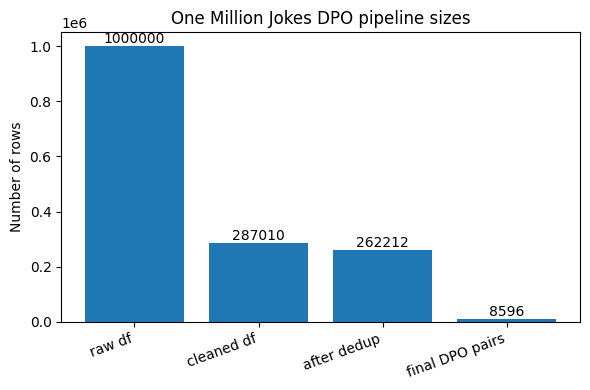

In [25]:
import matplotlib.pyplot as plt

stage_names = ["raw df", "cleaned df", "after dedup", "final DPO pairs"]
counts = [len(one_million_jokes), len(df), len(df_dedup), len(pairs_df)]

plt.figure(figsize=(6, 4))
plt.bar(stage_names, counts)
plt.title("One Million Jokes DPO pipeline sizes")
plt.ylabel("Number of rows")
plt.xticks(rotation=20, ha="right")

for i, v in enumerate(counts):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()
